# Basic Simulation Sample

This notebook contains the implementation of a very simple world simulation built with Neighborly. It uses roughly all the configuration parameters, including logging and shows potential users how to get started building simulations.

## Time

All worlds start at year zero (0) and time increments by one (1) year every time step.

## The settlement

Users can modify the size, name, and zoning make-up of the settlement using the, `settings` field in the simulation configuration.

# Step 1: Create and configure the simulation

In [1]:
from neighborly import Neighborly, NeighborlyConfig
from neighborly.utils.common import debug_print_gameobject

sim = Neighborly(
    NeighborlyConfig.parse_obj(
        {
#             "seed": "Apple",
            "plugins": [
                "neighborly.plugins.defaults.all",
                "neighborly.plugins.talktown"
            ],
            "logging": {
                "logging_enabled": False,
                "log_level": "INFO",
                "log_file_name": "neighborly.log",
                "log_directory": "."
            },
            "settings": {
                "settlement_size": (5, 5),  # Width/length of the settlement grid
                "settlement_name": "Sample City",
                "zoning": (0.5, 0.5),    # Zoning is 50/50 residential vs. commercial
                "character_spawn_table": [
                    {"name": "character::default::male"},
                    {"name": "character::default::female"},
                    {"name": "character::default::non-binary"},
                ],
                "residence_spawn_table": [
                    {"name": "residence::default::house"},
                ],
                "business_spawn_table": [
                    {
                        "name": "business::default::cafe",
                        "frequency": 1,
                        "max_instances": 9999,
                        "min_population": 0,
                        "year_available": 0,
                        "year_obsolete": 9999
                    },
                    {
                        "name": "business::default::library",
                        "frequency": 1,
                        "max_instances": 9999,
                        "min_population": 0,
                        "year_available": 0,
                        "year_obsolete": 9999
                    }
                ]
            }
        }
    )
)

# Step 1b: Configure data collection systems

For this we are going to track the population of the settlment. We are going to overlay this information on a plot containing the number of incoming residents and the number of departures.

In [2]:
from collections import defaultdict

from neighborly.core.ecs import ISystem, World, Event
from neighborly.core.settlement import Settlement
from neighborly.components.shared import Name
from neighborly.data_collection import DataCollector
from neighborly.decorators import system, on_any_event
from neighborly.systems import DataCollectionSystemGroup
from neighborly.core.time import SimDateTime
from neighborly.core.life_event import LifeEvent


@system(sim.world, system_group=DataCollectionSystemGroup)
class TrackPopulationSystem(ISystem):
    def on_create(self, world: World) -> None:
        world.resource_manager.get_resource(DataCollector).create_new_table(
            "population", ("name", "year", "population")
        )
    
    def on_update(self, world: World) -> None:
        current_year = world.resource_manager.get_resource(SimDateTime).year
        data_collector = world.resource_manager.get_resource(DataCollector)
        for _, (name, settlement) in world.get_components((Name, Settlement)):
            data_collector.add_table_row(
                "population",
                {
                    "name": name.value,
                    "year": current_year,
                    "population": settlement.population,
                },
            )
            
@on_any_event(sim.world)
def add_life_event_to_bin(event: Event):
    if isinstance(event, LifeEvent):
        event.world.system_manager.get_system(TrackLifeEventCounts).increment_bin(
            type(event).__name__
        )
            

@system(sim.world, system_group=DataCollectionSystemGroup)
class TrackLifeEventCounts(ISystem):
    
    def __init__(self) -> None:
        super().__init__()
        self.event_bins = defaultdict(lambda: 0)
        
    def increment_bin(self, event_type) -> None:
        self.event_bins[event_type] += 1
    
    def on_create(self, world: World) -> None:
        world.resource_manager.get_resource(DataCollector).create_new_table(
            "events", ("year", "event_type","count")
        )
    
    def on_update(self, world: World) -> None:
        current_year = world.resource_manager.get_resource(SimDateTime).year
        data_collector = world.resource_manager.get_resource(DataCollector)
        
        for event_type, count in self.event_bins.items():
            data_collector.add_table_row(
                "events",
                {
                    "year": current_year,
                    "event_type": event_type,
                    "count": count,
                },
            )
        
        # Clear for next year
        self.event_bins.clear()

# Step 2: Run step a single time to see what settlement(s) we have

By default, the `InitializeSettlementSystem` creates a single settlement using the settings provided in the `settlement` section of the Neighborly config defined above.

In [3]:
from neighborly.core.settlement import Settlement

sim.step()

guid, _ = sim.world.get_component(Settlement)[0]

settlement = sim.world.gameobject_manager.get_gameobject(guid)

debug_print_gameobject(settlement)

name: Sample City
uid: 113
components: [
	Name(Sample City)
	Settlement(population=9)
	Location(gameobjects=OrderedSet(), parent=, children=['residence::default::house(114)', 'residence::default::house(133)'])
	Age(1.0)
	Active()
]


# Step 3: Run the simulation for 20 years and see what happened

1. The settlement has ages by 20 years

In [4]:
from neighborly.components.character import GameCharacter
from neighborly.core.ecs import Active

sim.run_for(years=20)

print(f"{settlement.name} population: {settlement.get_component(Settlement).population}\n")

# Print who lives here
for guid, _ in sim.world.get_components((Active, GameCharacter)):
    character = sim.world.gameobject_manager.get_gameobject(guid)
    print(character.name)

Sample City population: 41

Sanderson Hamming(134)
Imogen Hamming(135)
Audry Hamming(138)
Frankie Hamming(144)
Patty Hamming(152)
Niels Fiveash(417)
Cleo Fiveash(418)
Adams Fiveash(421)
Trace Bruton(679)
Corenda Weedman(168)
Kristine Weedman(169)
Nat Fiveash(427)
Sunny Bicker(173)
Raymund Bicker(174)
Elsy Bicker(177)
Reese Fiveash(435)
Debbie Donaway(308)
Renell Donaway(309)
Aubrey Bicker(183)
Baillie Donaway(312)
Frankie Bluitt(446)
Ulberto Bicker(191)
Viviana Burston(319)
Kerry Burston(320)
Merle Bluitt(447)
Skylar Burston(323)
Libbi Burston(329)
Noach Burston(337)
Rory Reade(1373)
Milan Reade(1374)
Gregorio Reade(1377)
Zalman Goodkind(230)
Townsend Goodkind(231)
Joe Botting(235)
Johann Botting(236)
Blaire Botting(240)
Arvy Elkington(115)
Jodie Elkington(116)
Jan Botting(246)
Gaspar Elkington(119)
Armani Elkington(125)


Text(0.5, 1.0, 'Population of Simulation (seed: 5447217)')

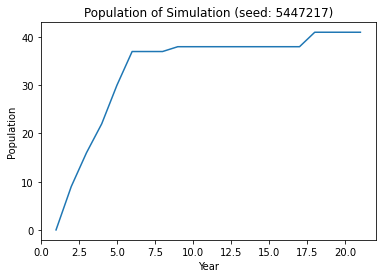

In [5]:
from neighborly.data_collection import DataCollector
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_collector = sim.world.resource_manager.get_resource(DataCollector)
population_table = data_collector.get_table_dataframe("population")

plt.plot(
    population_table["year"],
    population_table["population"]
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")

     year           event_type  count
0       2  JoinSettlementEvent      9
1       2   MoveResidenceEvent      9
2       3     NewBusinessEvent      1
3       3   StartBusinessEvent      1
4       3        StartJobEvent      3
..    ...                  ...    ...
120    21     StartDatingEvent      4
121    21        StartJobEvent      1
122    21         BreakUpEvent      2
123    21          EndJobEvent      3
124    21  BusinessClosedEvent      1

[125 rows x 3 columns]
['JoinSettlementEvent' 'MoveResidenceEvent' 'NewBusinessEvent'
 'StartBusinessEvent' 'StartJobEvent' 'DivorceEvent'
 'BecameAcquaintancesEvent' 'StartDatingEvent' 'BreakUpEvent'
 'EndJobEvent' 'BusinessClosedEvent' 'MarriageEvent']


Text(0.5, 1.0, 'Count of JoinSettlementEvents (seed: 5447217)')

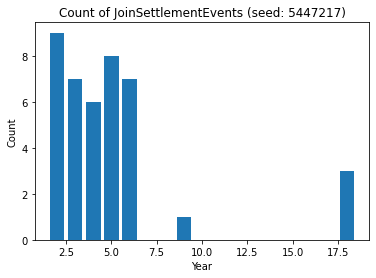

In [6]:
from neighborly.data_collection import DataCollector

data_collector = sim.world.resource_manager.get_resource(DataCollector)
event_counts = data_collector.get_table_dataframe("events")

print(event_counts)


print(event_counts["event_type"].unique())


join_events = event_counts[event_counts['event_type'] == "JoinSettlementEvent"]
depart_events = event_counts[event_counts['event_type'] == "DepartEvent"]
# print(join_events)


plt.bar(
    join_events["year"],
    join_events["count"]
)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"Count of JoinSettlementEvents (seed: {sim.config.seed})")